## **Modelo de Previsão de Preço de Imóveis**

In [2]:
!pip install pyspark

**Bibliotecas importadas**

In [3]:
from pyspark.sql import SparkSession
from google.colab import drive
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql import functions as f
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor


**Carregamento dos Dados**

### **Montando o *drive***


In [4]:
spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Regressão com Spark") \
    .getOrCreate()

spark

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
dados = spark.read.json(
    '/content/drive/MyDrive/aula01/imoveis.json',
    multiLine=False
)

In [7]:
dados.show(truncate=False)

+--------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ident                     |listing                                                                                                                                                          |
+--------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{775564-BOJSMVON, Website}|{{Rio de Janeiro, {-22.909429, -43.413557}, Taquara, Zona Oeste}, {0, 0, 0, 1, 0, 62, 0, 0, 62}, {45000, {150, 0}}, {Outros, Residencial}}                       |
|{660895-AUENKNYY, Website}|{{Rio de Janeiro, {-22.869698, -43.509141}, Santíssimo, Zona Oeste}, {1, 2, 0, 1, 0, 0, 0, 0, 44}, {45000, {120, 0}}, {Apartamento, Residencial}}                |
|{751522-JESYFEQL, Website}|{{Rio de Janeiro,

In [8]:
dados.count()

73615

## **Seleção de *Features***

In [9]:
dados\
    .select('ident.customerID', 'listing.*')\
    .show(truncate=False)

+---------------+--------------------------------------------------------------------------------+-------------------------------+---------------------+--------------------------+
|customerID     |address                                                                         |features                       |prices               |types                     |
+---------------+--------------------------------------------------------------------------------+-------------------------------+---------------------+--------------------------+
|775564-BOJSMVON|{Rio de Janeiro, {-22.909429, -43.413557}, Taquara, Zona Oeste}                 |{0, 0, 0, 1, 0, 62, 0, 0, 62}  |{45000, {150, 0}}    |{Outros, Residencial}     |
|660895-AUENKNYY|{Rio de Janeiro, {-22.869698, -43.509141}, Santíssimo, Zona Oeste}              |{1, 2, 0, 1, 0, 0, 0, 0, 44}   |{45000, {120, 0}}    |{Apartamento, Residencial}|
|751522-JESYFEQL|{Rio de Janeiro, {-22.986927, -43.646786}, Pedra de Guaratiba, Zona Oeste}      |{0

In [10]:
dados\
    .select('ident.customerID', 'listing.types.*', 'listing.features.*', 'listing.address.*', 'listing.prices.price', 'listing.prices.tax.*')\
    .show(truncate=False)

+---------------+-----------+-----------+---------+--------+------+-------------+------+----------+---------+---------------+-----------+--------------+------------------------+------------------------+------------+-----+-----+----+
|customerID     |unit       |usage      |bathrooms|bedrooms|floors|parkingSpaces|suites|totalAreas|unitFloor|unitsOnTheFloor|usableAreas|city          |location                |neighborhood            |zone        |price|condo|iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+----------+---------+---------------+-----------+--------------+------------------------+------------------------+------------+-----+-----+----+
|775564-BOJSMVON|Outros     |Residencial|0        |0       |0     |1            |0     |62        |0        |0              |62         |Rio de Janeiro|{-22.909429, -43.413557}|Taquara                 |Zona Oeste  |45000|150  |0   |
|660895-AUENKNYY|Apartamento|Residencial|1        |2       |0     |1

Verificação de **cidades dos imóveis** do dataset

In [11]:
dados\
    .select('ident.customerID', 'listing.types.*', 'listing.features.*', 'listing.address.*', 'listing.prices.price', 'listing.prices.tax.*')\
    .select('city')\
    .groupBy('city')\
    .count()\
    .show(truncate=False)

+------------------+-----+
|city              |count|
+------------------+-----+
|Cachoeirinha      |1    |
|São Gonçalo       |2    |
|Queimados         |3    |
|São João de Meriti|1    |
|Rio de Janeiro    |73607|
|Armação dos Búzios|1    |
+------------------+-----+



Como os dados dos imóveis são, em maioria, do Rio de Janeiro (RJ), será **removido os dados não pertencentes a cidade RJ**, bem como será excluída a feature city da análise.

In [12]:
dataset = dados\
    .select('ident.customerID', 'listing.types.*', 'listing.features.*', 'listing.address.*', 'listing.prices.price', 'listing.prices.tax.*') \
    .where(f.col("city") == "Rio de Janeiro") \
    .drop('location', 'totalAreas')

In [13]:
# Verificação das cidades em dataset
dataset.groupBy("city").count().show()

+--------------+-----+
|          city|count|
+--------------+-----+
|Rio de Janeiro|73607|
+--------------+-----+



**Remoção da Feature city** somente após remoção dos valores diferentes de "Rio de Janeiro"

In [14]:
dataset = dados\
    .select('ident.customerID', 'listing.types.*', 'listing.features.*', 'listing.address.*', 'listing.prices.price', 'listing.prices.tax.*')\
    .drop('city','location', 'totalAreas')

## **Tratamento de Dados**

In [15]:
# Verificação dos tipos das variáveis
dataset.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- usage: string (nullable = true)
 |-- bathrooms: long (nullable = true)
 |-- bedrooms: long (nullable = true)
 |-- floors: long (nullable = true)
 |-- parkingSpaces: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- unitFloor: long (nullable = true)
 |-- unitsOnTheFloor: long (nullable = true)
 |-- usableAreas: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- zone: string (nullable = true)
 |-- price: string (nullable = true)
 |-- condo: string (nullable = true)
 |-- iptu: string (nullable = true)



In [16]:
# Verificação de como ficaria o tratamento dos tipos incorretos
dataset\
    .withColumn('usableAreas', dataset['usableAreas'].cast(IntegerType()))\
    .withColumn('price', dataset['price'].cast(DoubleType()))\
    .withColumn('condo', dataset['condo'].cast(DoubleType()))\
    .withColumn('iptu', dataset['iptu'].cast(DoubleType()))\
    .printSchema()

root
 |-- customerID: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- usage: string (nullable = true)
 |-- bathrooms: long (nullable = true)
 |-- bedrooms: long (nullable = true)
 |-- floors: long (nullable = true)
 |-- parkingSpaces: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- unitFloor: long (nullable = true)
 |-- unitsOnTheFloor: long (nullable = true)
 |-- usableAreas: integer (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- zone: string (nullable = true)
 |-- price: double (nullable = true)
 |-- condo: double (nullable = true)
 |-- iptu: double (nullable = true)



In [17]:
# Validação do tratamento dos tipos incorretos
dataset = dataset\
    .withColumn('usableAreas', dataset['usableAreas'].cast(IntegerType()))\
    .withColumn('price', dataset['price'].cast(DoubleType()))\
    .withColumn('condo', dataset['condo'].cast(DoubleType()))\
    .withColumn('iptu', dataset['iptu'].cast(DoubleType()))

Verificação dos **tipos de imóveis** presentes no dataset

In [18]:
dataset\
    .select('usage')\
    .groupBy('usage')\
    .count()\
    .show()

+-----------+-----+
|      usage|count|
+-----------+-----+
|  Comercial| 4019|
|Residencial|69596|
+-----------+-----+



Escolha de manter **somente os imóveis do tipo Residencial (=95% dos dados)**

In [19]:
dataset = dataset\
    .select('*')\
    .where('usage=="Residencial"')

In [20]:
# Verificação dos tipos de imóveis
dataset\
    .select('unit')\
    .groupBy('unit')\
    .count()\
    .show()

+-----------+-----+
|       unit|count|
+-----------+-----+
|     Outros| 1190|
|Apartamento|59106|
|       Casa| 9300|
+-----------+-----+



**Observação:** seria necessário verificar o que seria **"Outros" em "unit"** nesse banco de dados

In [21]:
# Verificação de regiões
dataset\
    .select('zone')\
    .groupBy('zone')\
    .count()\
    .show()

+------------+-----+
|        zone|count|
+------------+-----+
|  Zona Norte|14379|
|  Zona Oeste|35523|
|Zona Central| 1002|
|    Zona Sul|18535|
|            |  157|
+------------+-----+



Foi verificado valores ***nulos em "zone"***, esses dados devem ser tratados

### Tratamento para dados faltantes


In [22]:
# Verificação dos dados nulos
dataset\
    .select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in dataset.columns])\
    .show()

+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|customerID|unit|usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood|zone|price|condo|iptu|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|         0|   0|    0|        0|       0|     0|            0|     0|        0|              0|          0|           0|   0|    0| 6061|8726|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+



Preenchimentos dos valores ***nulos com zero***

In [23]:
# Verificação de como ficaria o tratamento dos dados faltantes
dataset\
    .select('*')\
    .na\
    .fill(0)\
    .show()

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  price|condo| iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|  0.0|
|660895-AUENKNYY|Apartamento|Residencial|        1|       2|     0|            1|     0|        0|              0|         44|          Santíssimo|  Zona Oeste|45000.0|120.0|  0.0|
|751522-JESYFEQL|     Outros|Residencial|        0|       0|     0|            0|     0|       

In [24]:
# Validação do tratamento dos dados faltantes
dataset = dataset\
    .select('*')\
    .na\
    .fill(0)

In [25]:
# Contagem dos valores nulos
dataset\
    .select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in dataset.columns])\
    .show()

+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|customerID|unit|usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood|zone|price|condo|iptu|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|         0|   0|    0|        0|       0|     0|            0|     0|        0|              0|          0|           0|   0|    0|    0|   0|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+



**Remoção dos valores ausentes em zone** por representar uma porcentagem pequena dos dados ***(<1%)***

In [26]:
dataset = dataset\
    .where(f.col('zone') != '')

## **Preparação dos Dados**

### Variáveis Dummy

Aplicação de técnica de **Engenharia de Atributos** conhecida como *One-Hot Encoding*, utilizando a função `pivot` do Spark.
Conversão dos atributos categóricos textuais, como o tipo de unidade (`unit`), em um formato numérico binário.

>


Transformação fundamental, pois os algoritmos de Machine Learning operam com dados numéricos, e ao criar colunas que indicam a presença (`1`) ou ausência (`0`) de uma categoria, permitimos que o modelo utilize essa informação valiosa em seu processo de aprendizado.

In [27]:
dataset\
    .groupBy("customerID")\
    .pivot('unit')\
    .agg(f.lit(1))\
    .na\
    .fill(0)\
    .show()

+---------------+-----------+----+------+
|     customerID|Apartamento|Casa|Outros|
+---------------+-----------+----+------+
|062130-QKYMWGMV|          1|   0|     0|
|630945-AEEUPRXI|          0|   1|     0|
|994985-OZQNHQKH|          1|   0|     0|
|494674-JWXRZIBM|          1|   0|     0|
|458844-UJCRFSRI|          1|   0|     0|
|155284-BRCDAOIQ|          1|   0|     0|
|396742-DUXBHLRU|          1|   0|     0|
|916072-ZJXARAXO|          1|   0|     0|
|943843-BVTWWHRQ|          1|   0|     0|
|193126-MTNIIFQN|          1|   0|     0|
|319762-UXTTQYFS|          1|   0|     0|
|931151-GZCTKADB|          1|   0|     0|
|103840-OFKPFEZJ|          0|   1|     0|
|176885-NNKZRQGM|          0|   1|     0|
|926638-PBYRAZYR|          1|   0|     0|
|744421-IZJWISWB|          1|   0|     0|
|530012-TYGLQMER|          1|   0|     0|
|209407-GTEUOVKR|          1|   0|     0|
|289667-ZPHGFHJH|          1|   0|     0|
|859388-EYTPMKER|          1|   0|     0|
+---------------+-----------+----+

Criação de DataFrames de features para aplicação da técnica **one-hot encoding** nas variáveis multicategóricas

In [28]:
unit = dataset\
    .groupBy('customerID')\
    .pivot('unit')\
    .agg(f.lit(1))\
    .na\
    .fill(0)

In [29]:
zone = dataset\
    .groupBy('customerID')\
    .pivot('zone')\
    .agg(f.lit(1))\
    .na\
    .fill(0)

Após a criação dos DataFrames de features, o passo seguinte é consolidar todas essas informações em um único conjunto de dados que servirá como entrada para o modelo de Machine Learning.

Para isso, utilizamos a função `join` para mesclar sequencialmente o dataset principal com os DataFrames de features (`unit` e `zone`). A junção é realizada utilizando a coluna `customerID` como a chave comum, que serve como o elo de ligação entre as diferentes fontes de dados.

A escolha do método `how='inner'` é estratégica. Um **inner join** garante que o dataset final conterá apenas os `customerID`s que estão presentes em **todas** as tabelas que estão sendo unidas. Essa abordagem cria um conjunto de dados coeso e completo, eliminando registros parciais ou órfãos que poderiam introduzir ruído ou erros durante o treinamento do modelo. O resultado é uma matriz de features robusta e íntegra, pronta para a próxima etapa de modelagem.

In [30]:
dataset = dataset\
    .join(unit, 'customerID', how='inner')\
    .join(zone, 'customerID', how='inner')

In [31]:
# Verificação do DataFrame após preparação dos dados
dataset.show()

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  price|condo| iptu|Apartamento|Casa|Outros|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|  0.0|          0|   0|     1|           0|         0|         1|       0|
|660

### **Vetorização e Nomenclatura no Spark**

In [32]:
# Alteração da nomenclatura da variável a ser prevista
dataset = dataset.withColumnRenamed('price','label')

In [33]:
# Seleção das features
X = [
    'bathrooms',
    'bedrooms',
    'floors',
    'parkingSpaces',
    'suites',
    'unitFloor',
    'unitsOnTheFloor',
    'usableAreas',
    'condo',
    'iptu',
    'Apartamento',
    'Casa',
    'Outros',
    'Zona Central',
    'Zona Norte',
    'Zona Oeste',
    'Zona Sul'
]

In [34]:
# Vetorização usando o objeto assembler utilizando os valores que as funções do Spark esperam receber
assembler = VectorAssembler(inputCols = X, outputCol = 'features')

Embora a configuração do assembler tenha sido feita, não houve alteração no dataset. Para isso, será criado um **novo dataset preparado para receber as funções de machine learning do Spark.**

In [35]:
dataset_prep = assembler.transform(dataset).select('features', 'label')

Visualização do **dataset vetorizado.**


In [36]:
dataset_prep.show(10, truncate=False)

+--------------------------------------------------------------------------+-------+
|features                                                                  |label  |
+--------------------------------------------------------------------------+-------+
|(17,[3,7,8,12,15],[1.0,62.0,150.0,1.0,1.0])                               |45000.0|
|(17,[0,1,3,7,8,10,15],[1.0,2.0,1.0,44.0,120.0,1.0,1.0])                   |45000.0|
|(17,[7,8,12,15],[132.0,100.0,1.0,1.0])                                    |50000.0|
|[2.0,3.0,3.0,1.0,1.0,2.0,4.0,60.0,400.0,120.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0]|50000.0|
|(17,[7,12,15],[200.0,1.0,1.0])                                            |50000.0|
|(17,[0,1,3,7,10,14],[1.0,1.0,1.0,33.0,1.0,1.0])                           |45336.0|
|(17,[7,12,15],[120.0,1.0,1.0])                                            |45000.0|
|(17,[7,12,15],[468.0,1.0,1.0])                                            |45000.0|
|(17,[5,7,12,15],[1.0,180.0,1.0,1.0])                            

## **Exploração dos Dados**

Verificação de **multicolinearidade das features**

In [37]:
correlacao = Correlation.corr(dataset_prep, 'features').collect()

In [38]:
correlacao

[Row(pearson(features)=DenseMatrix(17, 17, [1.0, 0.6659, -0.0446, 0.4876, 0.7529, 0.0076, -0.1074, 0.5981, ..., 0.0088, 0.1803, -0.1833, -0.0165, -0.073, -0.3084, -0.6176, 1.0], False))]



*   Correlação em linha (row): mais de uma coluna e uma linha
*   Correlação de Pearson das features que é uma **DenseMatrix**
*   Seleção apenas do objeto da linha 1 e coluna 1: **Correlação de Pearson**




In [39]:
correlacao = Correlation.corr(dataset_prep, 'features').collect()[0][0]

Como temos uma matriz densa, ou seja, onde todos os zeros são representados, será necessário transformar em uma **matriz esparsa**, onde os zeros não são representados.
- **Transformação em array**

In [40]:
correlacao.toArray()

array([[ 1.00000000e+00,  6.65910814e-01, -4.45907541e-02,
         4.87590447e-01,  7.52927830e-01,  7.62425469e-03,
        -1.07437445e-01,  5.98072790e-01,  2.00298945e-02,
         1.51023977e-02, -2.75457964e-01,  3.43042378e-01,
        -1.40183420e-01, -9.73678190e-02, -1.62497441e-01,
         2.42345124e-01, -9.87517576e-02],
       [ 6.65910814e-01,  1.00000000e+00, -8.21840063e-02,
         4.67161260e-01,  6.01199220e-01, -7.16195849e-03,
        -1.30814438e-01,  5.63750247e-01,  1.84819307e-02,
         1.36391535e-02, -2.58339018e-01,  3.49962189e-01,
        -2.05607705e-01, -1.23732152e-01, -1.11711865e-01,
         1.63821698e-01, -4.94325200e-02],
       [-4.45907541e-02, -8.21840063e-02,  1.00000000e+00,
        -4.84861921e-02, -4.81062141e-02,  1.20981700e-01,
         7.37717422e-01, -1.03916850e-01,  1.37973623e-02,
         6.68849447e-03,  1.53947015e-01, -1.42089598e-01,
        -5.19462291e-02,  1.26044467e-01, -1.69262936e-02,
        -3.17495417e-02,  1.7

Criação de um **DataFrame do Pandas** passando essa correlação.toArray()

In [41]:
dataframe_correlacao = pd.DataFrame(correlacao.toArray(), columns=X, index=X)


In [42]:
# Verificação da Matriz de Correlação
dataframe_correlacao

,bathrooms,bedrooms,floors,parkingSpaces,suites,unitFloor,unitsOnTheFloor,usableAreas,condo,iptu,Apartamento,Casa,Outros,Zona Central,Zona Norte,Zona Oeste,Zona Sul
bathrooms,1.000000,0.665911,-0.044591,0.487590,0.752928,0.007624,-0.107437,0.598073,0.020030,0.015102,-0.275458,0.343042,-0.140183,-0.097368,-0.162497,0.242345,-0.098752
bedrooms,0.665911,1.000000,-0.082184,0.467161,0.601199,-0.007162,-0.130814,0.563750,0.018482,0.013639,-0.258339,0.349962,-0.205608,-0.123732,-0.111712,0.163822,-0.049433
floors,-0.044591,-0.082184,1.000000,-0.048486,-0.048106,0.120982,0.737717,-0.103917,0.013797,0.006688,0.153947,-0.142090,-0.051946,0.126044,-0.016926,-0.031750,0.017402
parkingSpaces,0.487590,0.467161,-0.048486,1.000000,0.484988,0.003768,-0.074527,0.483732,0.018012,0.009721,-0.252746,0.293326,-0.072359,-0.086437,-0.109957,0.267990,-0.178807
suites,0.752928,0.601199,-0.048106,0.484988,1.000000,0.005206,-0.091914,0.577636,0.023461,0.019093,-0.236217,0.282221,-0.088834,-0.084417,-0.230317,0.327546,-0.136398
unitFloor,0.007624,-0.007162,0.120982,0.003768,0.005206,1.000000,0.092359,-0.012748,0.003065,0.001200,0.034674,-0.031403,-0.013275,0.022315,-0.011112,0.007518,-0.004333
unitsOnTheFloor,-0.107437,-0.130814,0.737717,-0.074527,-0.091914,0.092359,1.000000,-0.144222,-0.000554,0.005029,0.147497,-0.137754,-0.045523,0.153639,0.030753,-0.012434,-0.055540
usableAreas,0.598073,0.563750,-0.103917,0.483732,0.577636,-0.012748,-0.144222,1.000000,0.019717,0.014656,-0.482170,0.459136,0.125672,-0.075256,-0.158553,0.192466,-0.051962
condo,0.020030,0.018482,0.013797,0.018012,0.023461,0.003065,-0.000554,0.019717,1.000000,0.226212,0.009105,-0.008624,-0.002495,-0.003553,-0.013453,-0.001055,0.014474
iptu,0.015102,0.013639,0.006688,0.009721,0.019093,0.001200,0.005029,0.014656,0.226212,1.000000,-0.001502,0.002291,-0.001870,-0.002438,-0.008400,-0.000428,0.008835


<img src='https://media.discordapp.net/attachments/888468711906893834/968929975963119626/unknown.png'>

# Representação visual da Matriz de Correlação

<Axes: >

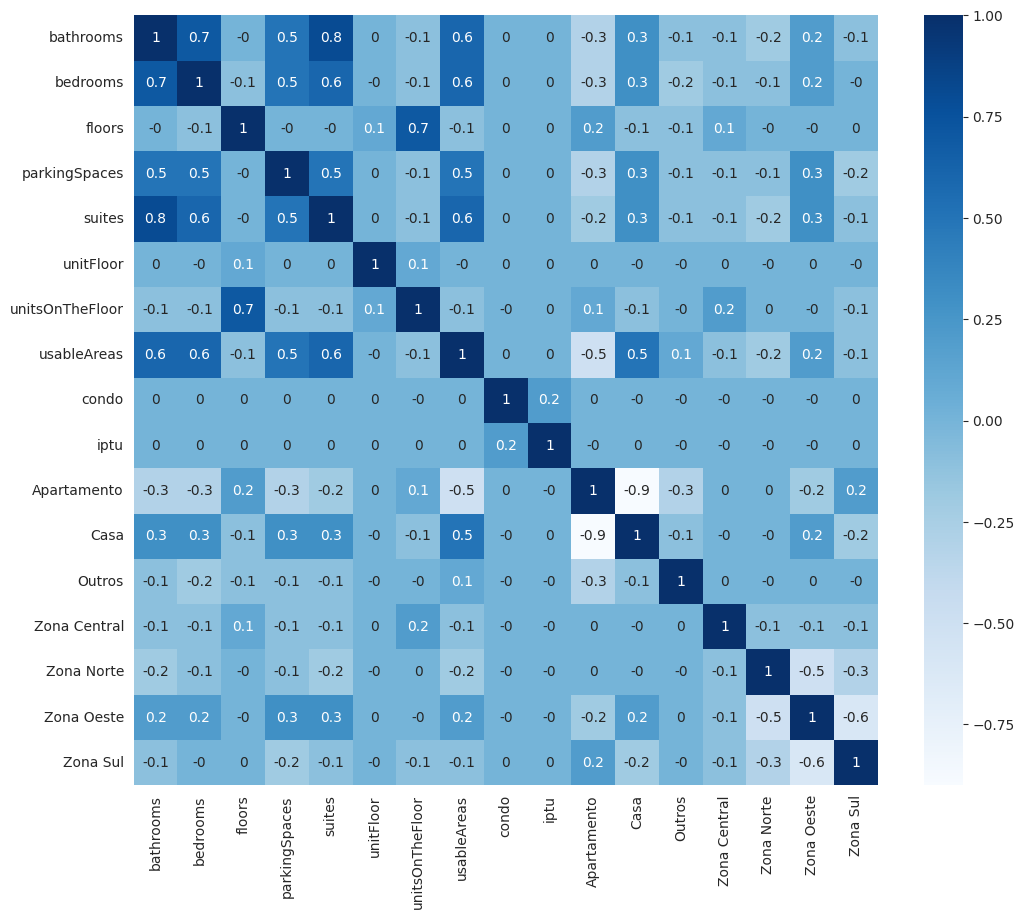

In [103]:
# Configuração da paleta
plt.figure(figsize=(12,10))
paleta = sns.color_palette("Blues", as_cmap=True)
sns.heatmap(dataframe_correlacao.round(1), annot=True, cmap=paleta)

Verificação de Multicolinearidade, ou seja, correlação dos dados de duas features: **banheiros e suítes (R=0.8).**

>

As features não serão removidas pois a correlação é < R=0.9, dessa forma, provavelmente a correlação observada não resultará em redundância no modelo.



## **Ajuste e Previsão**


Divisão dos dados em 70% treino e 30% teste.

In [44]:
# Seed=101 para aumentar reprodutibilidade do modelo
treino, teste = dataset_prep.randomSplit([0.7, 0.3], seed=101)

In [45]:
# Contagem dos valores de treino após separação dos dados
treino.count()

48528

In [46]:
# Contagem dos valores de teste após separação dos dados
teste.count()

20911

Criação do **objeto regressor** para **Regressão Linear**

In [47]:
lr = LinearRegression()

In [48]:
# Ajuste dos dados de treino ao objeto regressor
modelo_lr = lr.fit(treino)

In [49]:
# Previsões para os dados de treino
previsoes_lr_treino = modelo_lr.transform(treino)

In [50]:
# Visualização das previsões
previsoes_lr_treino.show()

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(17,[0,1,2,3,4,5,...|260000.0|443266.04737020144|
|(17,[0,1,2,3,4,5,...|500000.0|1127455.8300462805|
|(17,[0,1,2,3,4,5,...|308615.0|111210.49949889386|
|(17,[0,1,2,3,4,5,...|279000.0|113587.95787719043|
|(17,[0,1,2,3,4,5,...|545000.0|340703.71307873435|
|(17,[0,1,2,3,4,5,...|449000.0|390571.99595798284|
|(17,[0,1,2,3,4,5,...|479000.0| 444003.4297194885|
|(17,[0,1,2,3,4,5,...|420000.0| 720022.1542161054|
|(17,[0,1,2,3,4,5,...|265000.0|519406.05037395435|
|(17,[0,1,2,3,4,5,...|490000.0| 845483.5388437647|
|(17,[0,1,2,3,4,5,...|650000.0| 644931.4982488954|
|(17,[0,1,2,3,4,5,...|379900.0| 448889.3339027724|
|(17,[0,1,2,3,4,5,...|449000.0| 714548.9501108339|
|(17,[0,1,2,3,4,5,...|190000.0| 411726.9411630478|
|(17,[0,1,2,3,4,5,...|896000.0| 597499.4601552959|
|(17,[0,1,2,3,4,5,...|679000.0| 864544.0129262989|
|(17,[0,1,2,3,4,5,...|620000.0|

## **Métricas**

Métricas para avaliação do modelo
- RMSE (Raiz do erro quadrado médio): Diferença entre os valores previstos por um modelo e os valores reais observados, ou seja, mede o erro.
- R2: Medida estatística que representa a proporção de variância explicada pelas váriaveis independentes (features) em um modelo de regressão, ou seja, quanto o modelo está ajustado aos dados.

In [51]:
# Sumário do modelo - treino
resumo_treino = modelo_lr.summary

In [52]:
# Verificação do RMSE - teino
resumo_treino.rootMeanSquaredError

810348.969531623

In [53]:
# Verificação do R2 - treino
resumo_treino.r2

0.6655873678454578

In [54]:
# Avaliação das métrica para o conjunto de teste
resumo_teste = modelo_lr.evaluate(teste)

In [55]:
# Verificação do RMSE - teste
resumo_teste.rootMeanSquaredError

800525.9696828632

In [56]:
# Verificação do R2 - teste
resumo_teste.r2

0.6585207937774393

### **Tabela Resumo Regressão Linear**

Geração de tabela resumo para avaliação do modelo de Regressão Linear e para fulturas consultas e comparação entre modelos

In [57]:
print('Linear Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % resumo_treino.r2)
print("RMSE: %f" % resumo_treino.rootMeanSquaredError)
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % resumo_teste.r2)
print("RMSE: %f" % resumo_teste.rootMeanSquaredError)

Linear Regression
Dados de Treino
R²: 0.665587
RMSE: 810348.969532

Dados de Teste
R²: 0.658521
RMSE: 800525.969683


## **Modelo de Árvore de Decisão**

Escolha dos parâmetros:
- **seed=191** para **reprodutibilidade**
- **maxDepth=7** representa a **profundidade** da árvore, ou seja, o número de decisões até chegar na regressão final

In [58]:
# Criação do objeto regressão com os parâmetros definidos
dtr = DecisionTreeRegressor(seed=191, maxDepth=7)

In [59]:
# Ajuste dos dados de treino
modelo_dtr = dtr.fit(treino)

In [60]:
# Previsão com base nos dados de treino
previsoes_dtr_treino = modelo_dtr.transform(treino)

In [61]:
# Visualização das previsões - treino
previsoes_dtr_treino.show()

+--------------------+--------+-----------------+
|            features|   label|       prediction|
+--------------------+--------+-----------------+
|(17,[0,1,2,3,4,5,...|260000.0|340855.8044843049|
|(17,[0,1,2,3,4,5,...|500000.0|551560.6692818346|
|(17,[0,1,2,3,4,5,...|308615.0|340855.8044843049|
|(17,[0,1,2,3,4,5,...|279000.0|340855.8044843049|
|(17,[0,1,2,3,4,5,...|545000.0|    445137.460625|
|(17,[0,1,2,3,4,5,...|449000.0|551560.6692818346|
|(17,[0,1,2,3,4,5,...|479000.0|    445137.460625|
|(17,[0,1,2,3,4,5,...|420000.0|551560.6692818346|
|(17,[0,1,2,3,4,5,...|265000.0|551560.6692818346|
|(17,[0,1,2,3,4,5,...|490000.0|845048.3603896104|
|(17,[0,1,2,3,4,5,...|650000.0|747938.5945633315|
|(17,[0,1,2,3,4,5,...|379900.0|    445137.460625|
|(17,[0,1,2,3,4,5,...|449000.0|    445137.460625|
|(17,[0,1,2,3,4,5,...|190000.0|340855.8044843049|
|(17,[0,1,2,3,4,5,...|896000.0|551560.6692818346|
|(17,[0,1,2,3,4,5,...|679000.0|845048.3603896104|
|(17,[0,1,2,3,4,5,...|620000.0|551560.6692818346|


## **Métricas**

Criação do objeto **evaluator** da biblioteca Pyspark para avaliação do modelo

In [62]:
evaluator = RegressionEvaluator()

Avaliação das mesmas métricas utilizadas para a Regressão Linear para comparação dos modelos

In [63]:
# Métricas R2 e RMSE - treino
print(evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "r2"}))
print(evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "rmse"}))

0.7929460835083209
637635.4762225805


In [64]:
# Previsões para o conjunto de teste
previsoes_dtr_teste = modelo_dtr.transform(teste)

In [65]:
# Visualização das previsões para o conjunto de teste
previsoes_dtr_teste.show()

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(17,[0,1,2,3,4,5,...| 199000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...| 350000.0| 845048.3603896104|
|(17,[0,1,2,3,4,5,...| 340000.0| 551560.6692818346|
|(17,[0,1,2,3,4,5,...| 430000.0| 551560.6692818346|
|(17,[0,1,2,3,4,5,...| 600000.0| 551560.6692818346|
|(17,[0,1,2,3,4,5,...| 439000.0| 551560.6692818346|
|(17,[0,1,2,3,4,5,...| 333000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...| 948000.0| 747938.5945633315|
|(17,[0,1,2,3,4,5,...| 459600.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...| 447600.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...| 360000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...| 407000.0| 551560.6692818346|
|(17,[0,1,2,3,4,5,...| 310000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...|1400000.0|1210691.5737113403|
|(17,[0,1,2,3,4,5,...|1180000.0|1210691.5737113403|
|(17,[0,1,2,3,4,5,...|1299500.0|1210691.5737113403|
|(17,[0,1,2,

In [66]:
# Métricas R2 e RMSE - teste
print(evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}))
print(evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}))

0.7731591207864223
652460.0944905207


### Geração de **tabela resumo** para avaliação do modelo de Árvore de Decisão

In [67]:
print('Decision Tree Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}))

Decision Tree Regression
Dados de Treino
R²: 0.792946
RMSE: 637635.476223

Dados de Teste
R²: 0.773159
RMSE: 652460.094491


# **Modelo Random Forest - Regressão**

O modelo Random Forest é chamado de **método de aprendizado de ensemble** (bootstrap agregation - **bagging**), ao qual é utilizado diferentes algoritmos combinados para obtenção da predição mais correta (modelo **mais complexo**)

Escolha dos parâmetros:

- seed=101 para reprodutibilidade
- maxDepth=7 profundidade da árvore (mesmo que o modelo de Árvore de Decisão)
- numTrees=10 representa o número de árvores


In [68]:
# Criação do objeto regressão com os parâmetros definidos
rfr = RandomForestRegressor(seed=101, maxDepth=7, numTrees=10)

In [69]:
# Ajuste dos dados de treino
modelo_rfr = rfr.fit(treino)

In [70]:
# Previsão com base nos dados de treino
previsoes_rfr_treino = modelo_rfr.transform(treino)

In [71]:
# Visualização das previsões - treino
previsoes_rfr_treino.show()

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(17,[0,1,2,3,4,5,...|260000.0|390218.33742322924|
|(17,[0,1,2,3,4,5,...|500000.0| 510060.6595782173|
|(17,[0,1,2,3,4,5,...|308615.0|360766.74127901345|
|(17,[0,1,2,3,4,5,...|279000.0|360766.74127901345|
|(17,[0,1,2,3,4,5,...|545000.0|  396904.928725379|
|(17,[0,1,2,3,4,5,...|449000.0|  492913.652312712|
|(17,[0,1,2,3,4,5,...|479000.0|433807.13396085694|
|(17,[0,1,2,3,4,5,...|420000.0| 664440.4325776277|
|(17,[0,1,2,3,4,5,...|265000.0|479615.50733929937|
|(17,[0,1,2,3,4,5,...|490000.0| 816123.0337632223|
|(17,[0,1,2,3,4,5,...|650000.0| 640247.1517314625|
|(17,[0,1,2,3,4,5,...|379900.0|403131.21721626434|
|(17,[0,1,2,3,4,5,...|449000.0|403131.21721626434|
|(17,[0,1,2,3,4,5,...|190000.0| 356904.3339549792|
|(17,[0,1,2,3,4,5,...|896000.0| 547828.3209496561|
|(17,[0,1,2,3,4,5,...|679000.0| 893791.6624292185|
|(17,[0,1,2,3,4,5,...|620000.0|

## **Métricas**

In [72]:
# Métricas R2 e RMSE - teste
print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}))
print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}))

0.8017561510914318
623922.4426224458


In [73]:
# Previsões com base no conjunto de teste
previsoes_rfr_teste = modelo_rfr.transform(teste)

In [74]:
# Visualização das previsçoes - teste
previsoes_rfr_teste.show()

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(17,[0,1,2,3,4,5,...| 199000.0| 350678.0454640939|
|(17,[0,1,2,3,4,5,...| 350000.0| 792518.9735011571|
|(17,[0,1,2,3,4,5,...| 340000.0|479615.50733929937|
|(17,[0,1,2,3,4,5,...| 430000.0| 526635.5362588142|
|(17,[0,1,2,3,4,5,...| 600000.0| 526635.5362588142|
|(17,[0,1,2,3,4,5,...| 439000.0| 550795.8732599718|
|(17,[0,1,2,3,4,5,...| 333000.0| 356904.3339549792|
|(17,[0,1,2,3,4,5,...| 948000.0| 640247.1517314625|
|(17,[0,1,2,3,4,5,...| 459600.0| 356904.3339549792|
|(17,[0,1,2,3,4,5,...| 447600.0| 356904.3339549792|
|(17,[0,1,2,3,4,5,...| 360000.0| 356904.3339549792|
|(17,[0,1,2,3,4,5,...| 407000.0|  492913.652312712|
|(17,[0,1,2,3,4,5,...| 310000.0|412580.35636663495|
|(17,[0,1,2,3,4,5,...|1400000.0| 1375418.570408164|
|(17,[0,1,2,3,4,5,...|1180000.0| 1375418.570408164|
|(17,[0,1,2,3,4,5,...|1299500.0|1111896.8209940076|
|(17,[0,1,2,

### Geração de **tabela resumo** para avaliação do modelo Random Forest

In [75]:
print('Random Forest Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))

Random Forest Regression
Dados de Treino
R²: 0.801756
RMSE: 623922.442622

Dados de Teste
R²: 0.790530
RMSE: 626981.467738


# **Técnicas de Otimização**

## **Árvore de Decisão com Cross Validation**

In [76]:
# Criação do objeto regressor
dtr = DecisionTreeRegressor()

**Criação do grid** com os parâmetros que serão testados para a **Árvore de Decisão**
- MaxDepth = profundidade máxima da árvore (complexidade)
- MaxBind = binning (granularidade do modelo)

In [77]:
# Criação do grid com os parâmetros
grid = ParamGridBuilder() \
    .addGrid(dtr.maxDepth, [2, 5, 10]) \
    .addGrid(dtr.maxBins, [10, 32, 45]) \
    .build()

In [78]:
# Novo evaluator
evaluator = RegressionEvaluator()

**Configuração do Cross Validator para a Árvore de Decisão**
- Estimador
- Parâmetros selecionados
- Evaluator
- Número de folds (separação do modelo em treino e teste)

In [79]:
# Criação do modelo com Cross Validator
dtr_cv = CrossValidator(
    estimator=dtr,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3,
        seed = 101
)

In [80]:
# Ajuste do modelo aos dados
modelo_dtr_cv = dtr_cv.fit(treino)

In [81]:
# Previsão tendo como base os dados de teste
previsoes_dtr_cv_teste = modelo_dtr_cv.transform(teste)

Geração de tabela resumo para avaliação do modelo **Árvore de Decisão com Cross Validation**

In [82]:
print('Decision Tree Regression')
print("="*30)
print("Sem Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Com Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_cv_teste, {evaluator.metricName: "rmse"}))

Decision Tree Regression
Sem Cross Validation
R²: 0.773159
RMSE: 652460.094491

Com Cross Validation
R²: 0.783773
RMSE: 637012.420358


## **Random Forest com Cross Validation**


In [83]:
# Criação do objeto regressor
rfr = RandomForestRegressor()

**Criação do grid** com os parâmetros que serão testados para **Random Forest**

- MaxDepth = profundidade máxima da árvore (complexidade)
- MaxBind = binning (granularidade do modelo)
- NumTrees = número de árvores de decisão individuais que serão construídas para formar a "floresta"

In [84]:
# Criação do grid com os parâmetros
grid = ParamGridBuilder() \
    .addGrid(rfr.numTrees, [10, 20, 30]) \
    .addGrid(rfr.maxDepth, [5, 10]) \
    .addGrid(rfr.maxBins, [10, 32, 45]) \
    .build()

In [85]:
# Novo evaluator
evaluator = RegressionEvaluator()

**Configuração do Cross Validator para Random Forest**

- Estimador
- Parâmetros selecionados
- Evaluator
- Número de folds (separação do modelo em treino e teste)

In [86]:
# Criação do modelo com Cross Validator
rfr_cv = CrossValidator(
    estimator=rfr,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3
)

In [87]:
# Ajuste do modelo aos dados
modelo_rfr_cv = rfr_cv.fit(treino)

In [88]:
# Previsão tendo como base os dados de teste
previsoes_rfr_cv_teste = modelo_rfr_cv.transform(teste)

Geração de tabela resumo para avaliação do modelo **Random Forest com Cross Validation**

In [89]:
print('Random Forest Regression')
print("="*30)
print("Sem Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Com Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "rmse"}))

Random Forest Regression
Sem Cross Validation
R²: 0.790530
RMSE: 626981.467738

Com Cross Validation
R²: 0.831605
RMSE: 562157.227221


# Visualização gráfica do ajuste dos melhores modelos

Criando amostra de 15.0% dos dados de teste...
Amostragem e conversão finalizadas.


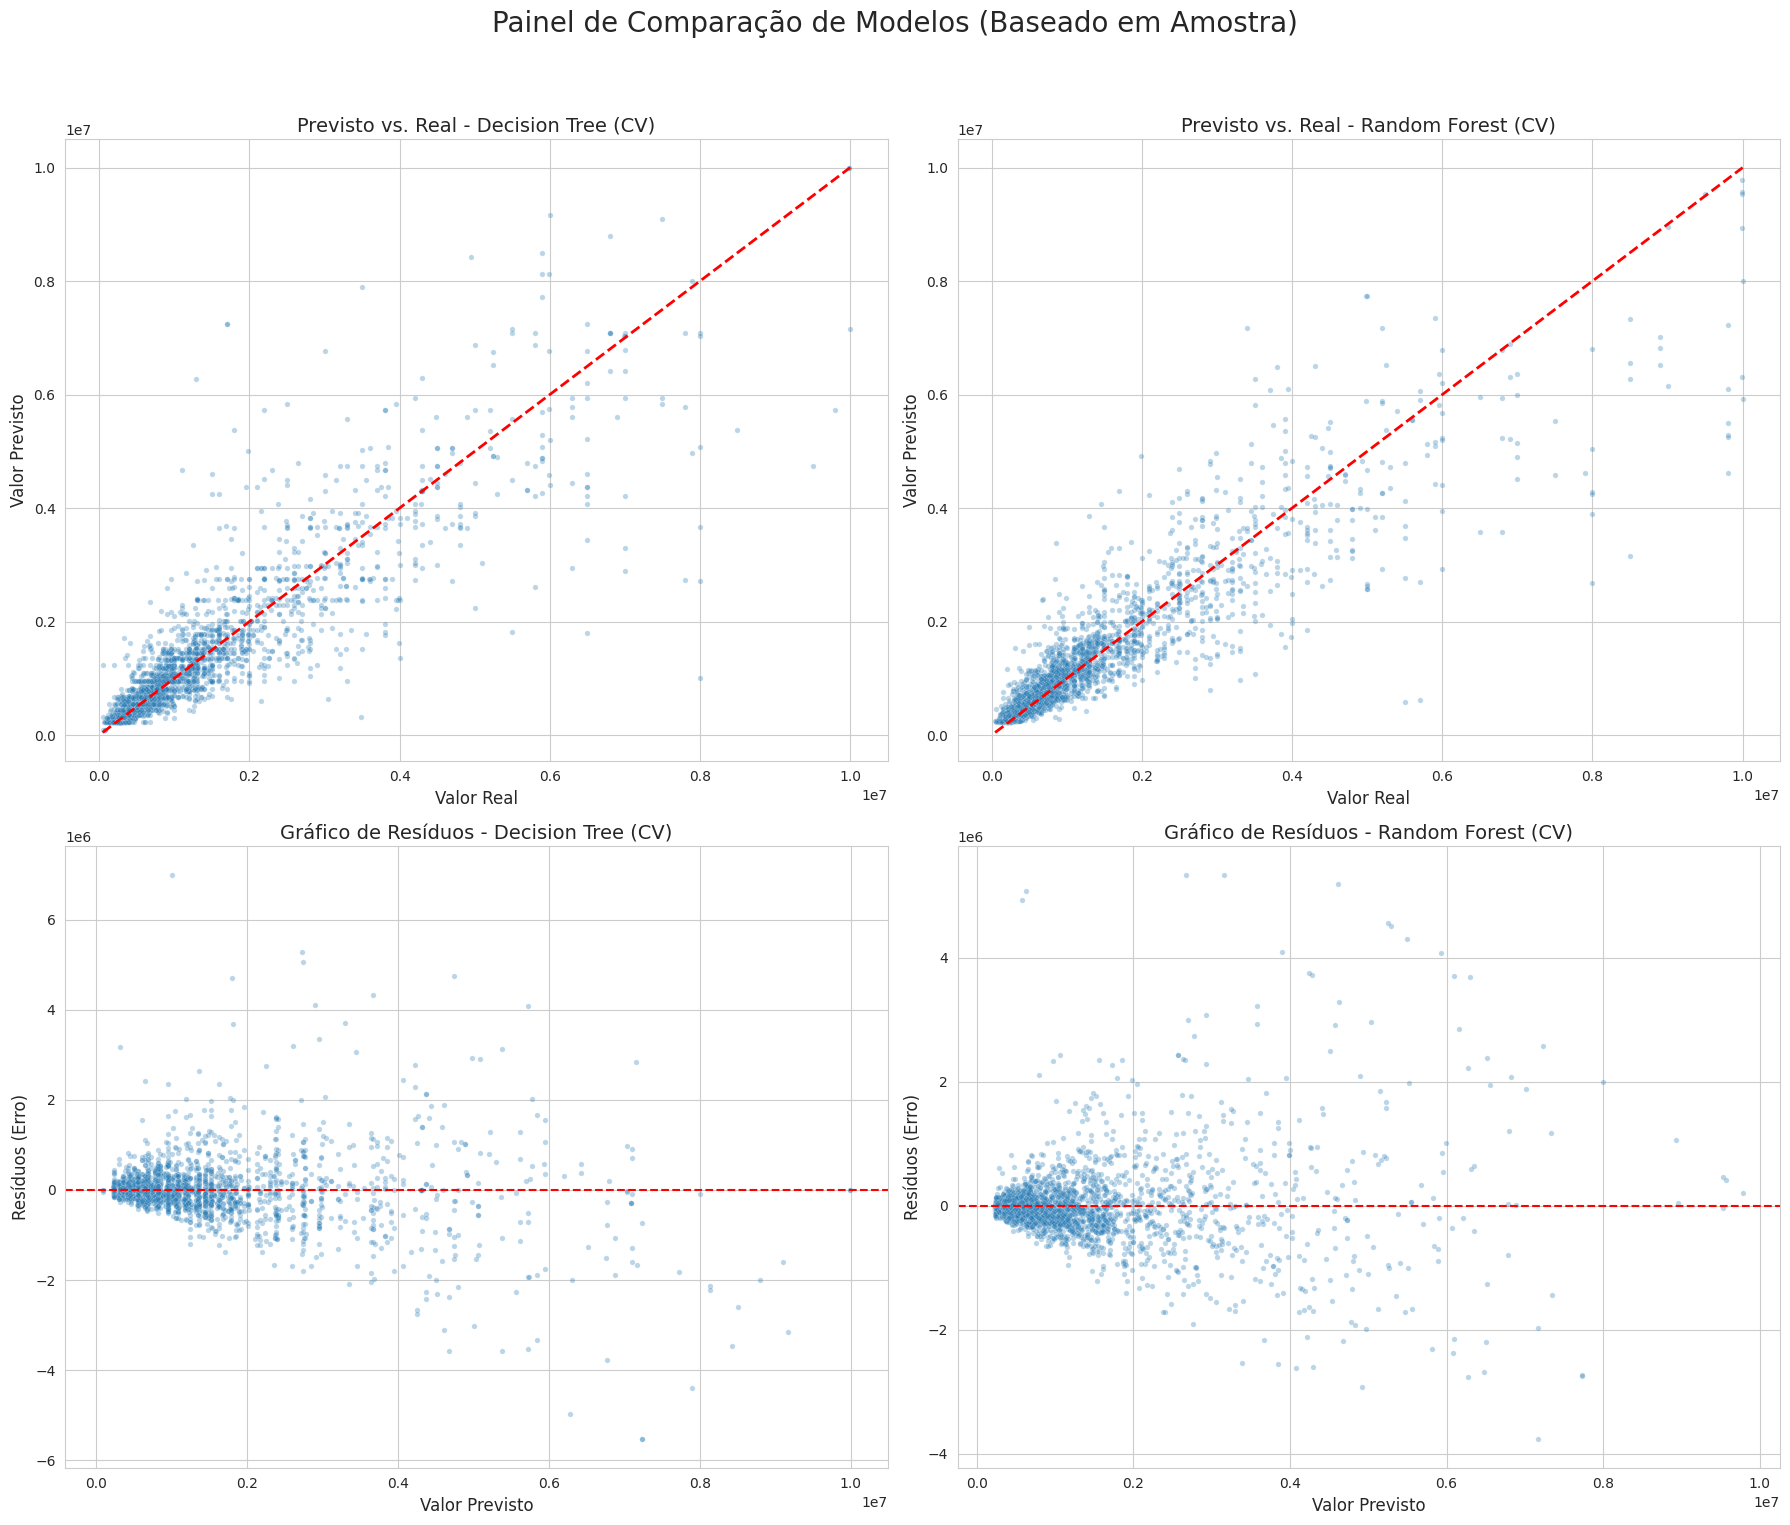

In [97]:
# -------------------------------------------------------------------
# Passo 1: Criar uma AMOSTRA dos resultados e converter para Pandas
# -------------------------------------------------------------------
# Definindo uma fração para a amostragem. 0.15 = 15% (aprox. 10.500 pontos)
sample_fraction = 0.15

print(f"Criando amostra de {sample_fraction*100}% dos dados de teste...")
dtr_cv_df_sample = previsoes_dtr_cv_teste.sample(withReplacement=False, fraction=sample_fraction).toPandas()
rfr_cv_df_sample = previsoes_rfr_cv_teste.sample(withReplacement=False, fraction=sample_fraction).toPandas()
print("Amostragem e conversão finalizadas.")

# Calculando os resíduos (erros) para cada modelo na amostra
dtr_cv_df_sample['residuos'] = dtr_cv_df_sample['label'] - dtr_cv_df_sample['prediction']
rfr_cv_df_sample['residuos'] = rfr_cv_df_sample['label'] - rfr_cv_df_sample['prediction']


# -------------------------------------------------------------------
# Passo 2: Criar a figura com 4 subplots (painel 2x2)
# -------------------------------------------------------------------
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(18, 16))
fig.suptitle('Painel de Comparação de Modelos (Baseado em Amostra)', fontsize=20)


# --- Parâmetros de visualização para dados densos ---
# alpha: transparência dos pontos (valores baixos revelam densidade)
# s: tamanho dos pontos
plot_params = {'alpha': 0.3, 's': 15}


# -------------------------------------------------------------------
# Gráfico 1: Previsto vs. Real - Decision Tree
# -------------------------------------------------------------------
ax1 = axes[0, 0]
ax1.plot([min(dtr_cv_df_sample['label']), max(dtr_cv_df_sample['label'])],
         [min(dtr_cv_df_sample['label']), max(dtr_cv_df_sample['label'])],
         'r--', lw=2)
sns.scatterplot(data=dtr_cv_df_sample, x='label', y='prediction', ax=ax1, **plot_params)
ax1.set_title('Previsto vs. Real - Decision Tree (CV)', fontsize=14)
ax1.set_xlabel('Valor Real', fontsize=12)
ax1.set_ylabel('Valor Previsto', fontsize=12)


# -------------------------------------------------------------------
# Gráfico 2: Previsto vs. Real - Random Forest
# -------------------------------------------------------------------
ax2 = axes[0, 1]
ax2.plot([min(rfr_cv_df_sample['label']), max(rfr_cv_df_sample['label'])],
         [min(rfr_cv_df_sample['label']), max(rfr_cv_df_sample['label'])],
         'r--', lw=2)
sns.scatterplot(data=rfr_cv_df_sample, x='label', y='prediction', ax=ax2, **plot_params)
ax2.set_title('Previsto vs. Real - Random Forest (CV)', fontsize=14)
ax2.set_xlabel('Valor Real', fontsize=12)
ax2.set_ylabel('Valor Previsto', fontsize=12)


# -------------------------------------------------------------------
# Gráfico 3: Resíduos - Decision Tree
# -------------------------------------------------------------------
ax3 = axes[1, 0]
ax3.axhline(y=0, color='r', linestyle='--')
sns.scatterplot(data=dtr_cv_df_sample, x='prediction', y='residuos', ax=ax3, **plot_params)
ax3.set_title('Gráfico de Resíduos - Decision Tree (CV)', fontsize=14)
ax3.set_xlabel('Valor Previsto', fontsize=12)
ax3.set_ylabel('Resíduos (Erro)', fontsize=12)


# -------------------------------------------------------------------
# Gráfico 4: Resíduos - Random Forest
# -------------------------------------------------------------------
ax4 = axes[1, 1]
ax4.axhline(y=0, color='r', linestyle='--')
sns.scatterplot(data=rfr_cv_df_sample, x='prediction', y='residuos', ax=ax4, **plot_params)
ax4.set_title('Gráfico de Resíduos - Random Forest (CV)', fontsize=14)
ax4.set_xlabel('Valor Previsto', fontsize=12)
ax4.set_ylabel('Resíduos (Erro)', fontsize=12)


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


##Prevendo Resultados com o Melhor modelo

In [90]:
X

['bathrooms',
 'bedrooms',
 'floors',
 'parkingSpaces',
 'suites',
 'unitFloor',
 'unitsOnTheFloor',
 'usableAreas',
 'condo',
 'iptu',
 'Apartamento',
 'Casa',
 'Outros',
 'Zona Central',
 'Zona Norte',
 'Zona Oeste',
 'Zona Sul']

In [91]:
   novo_imovel = [{
    'bathrooms': 2,
    'bedrooms': 2,
    'floors': 2,
    'parkingSpaces': 1,
    'suites': 2,
    'unitFloor':2,
    'unitsOnTheFloor':1,
    'usableAreas':150,
    'condo':400,
    'iptu':0,
    'Apartamento':1,
    'Casa':0,
    'Outros':0,
    'Zona Central':0,
    'Zona Norte':0,
    'Zona Oeste':0,
    'Zona Sul':1,
        'label': 0}]

In [92]:
meu_imovel = spark.createDataFrame(novo_imovel)

In [93]:
assembler = VectorAssembler(inputCols = X, outputCol = 'features')

In [94]:
meu_lar_vetorizado = assembler.transform(meu_imovel).select('features', 'label')

In [95]:
modelo_rfr_cv.transform(meu_lar_vetorizado).show()

+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[2.0,2.0,2.0,1.0,...|    0|1871882.0769263466|
+--------------------+-----+------------------+

